# Classification. Linear models and KNN

In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [8]:
from sklearn.exceptions import NotFittedError

In [9]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_hist = [];
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return(1/(1+ np.exp(np.dot(-X, weights))))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        m1 = np.dot(x, weights);
        M = np.dot(y, m1);
        loss = np.log(1 + np.exp(-M));
        self.loss_hist.append(loss);
        return loss;  
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        N = len(y);
        
        for i in range(self.max_iter):
            
            delta = np.dot(X_ext.T, np.dot(X_ext, self.weights_) - y) / len(y) / (2.0 * self.C);
            temp = self.weights_;
            self.weights_ -= self.eta * delta;
            
            self.get_loss(X_ext, self.weights_, y);
            #self.loss_hist.append(np.power(np.sum(np.power(self.weights_ - temp,2)), 0.5));
            if np.power(np.sum(np.power(self.weights_,2)), 0.5) < self.tol:
                break;
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            y = self.get_sigmoid(X_ext, self.weights_);
            y[y>=0.5] = 1;
            y[y<0.5] = -1;
            return y;
            

In [10]:
from sklearn import datasets
from sklearn import metrics

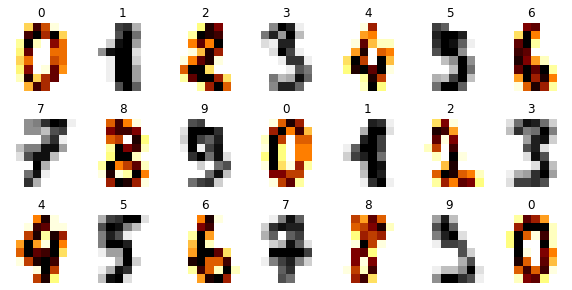

In [11]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [12]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [13]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [14]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [544]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [545]:
lr_clf.fit(X_train, y_train)

In [546]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [547]:
model = CustomLogisticRegression()

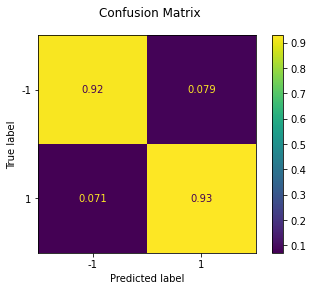

In [548]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test);

In [549]:
train_acc, test_acc

(0.9171885873347251, 0.925)

In [550]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

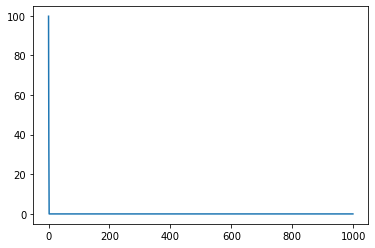

In [551]:
## your code
plt.plot(model.loss_hist)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

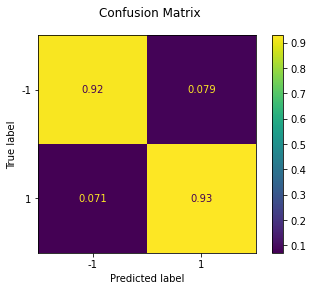

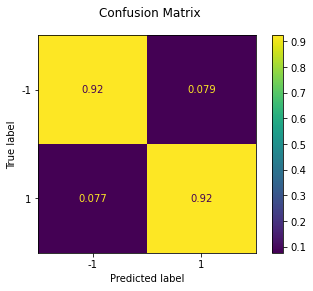

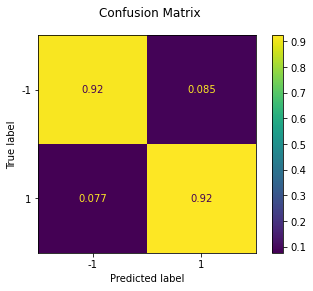

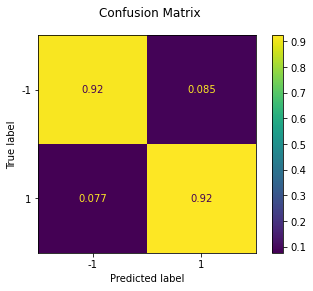

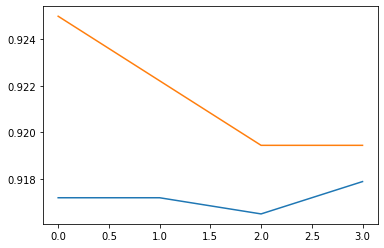

In [552]:
## your code
ETA=[0.001, 0.0012, 0.0013, 0.0014]
train_a = [];
test_a = [];
for eta in ETA:
    model = CustomLogisticRegression(eta=eta);
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test);
    train_a.append(train_acc);
    test_a.append(test_acc);
plt.plot(train_a);
plt.plot(test_a);

< your thoughts >

**(0.5 points)** Try different regularization parameter values and compare the model quality.

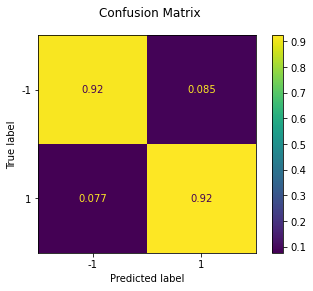

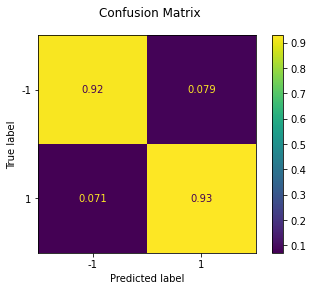

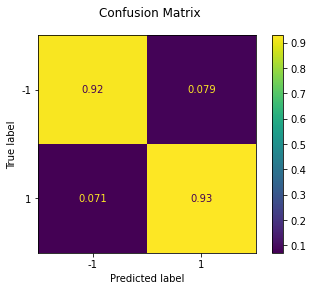

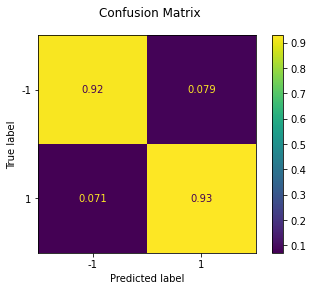

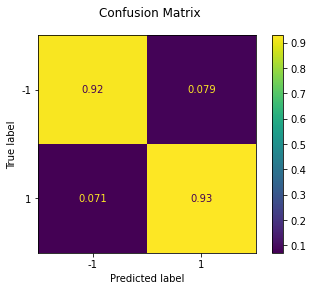

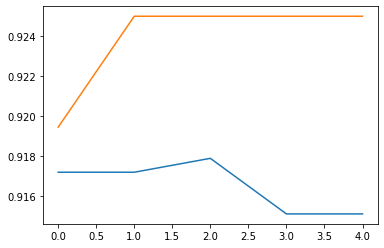

In [553]:
## your code
C=[0.8, 1, 1.2, 1.4, 1.6];
train_a = [];
test_a = [];
for c in C:
    model = CustomLogisticRegression(C=c);
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test);
    train_a.append(train_acc);
    test_a.append(test_acc);
plt.plot(train_a, label='train_acc');
plt.plot(test_a, label='test_acc');

< your thoughts >

**(0.5 points)** Compare zero initialization and random initialization. 

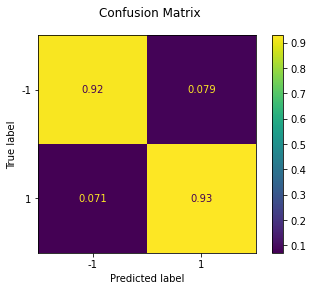

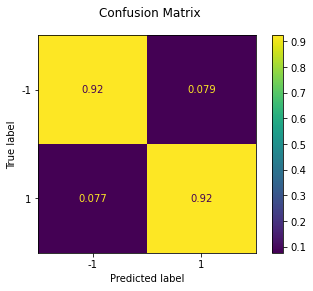

In [554]:
## your code
model = CustomLogisticRegression(zero_init = False);
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test);
model = CustomLogisticRegression(zero_init = True);
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test);

< your thoughts >

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [147]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps

    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        res = [];
        
        for i in range(X.shape[0]):
            dis = [];
            for j in range(Y.shape[1]):
                dis.append(np.linalg.norm(X[i] - Y[j], axis=0));
        
            res.append(dis);
   
        return np.array(res);
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        p = [];
        df_weight = pd.DataFrame({'y':y, 'weights':weights})
        for i in self.classes_:
            p.append(df_weight[df_weight['y'] == i]['weights'].sum());
        return p;
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            
            P = self.get_pairwise_distances(X, self.points);
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                y_test_predict=[];
                res_p = [];
                for p in P:
                    weights_of_points = sorted(zip(p, self.y));
                    k_nearest_neighbors_target = [items[1] for items in weights_of_points[:self.n_neighbors]];
                    pr = max(set(k_nearest_neighbors_target), key=k_nearest_neighbors_target.count);
                    y_test_predict.append(pr);
                    res_p.append(np.zeros(len(self.classes_)));
                    res_p[-1][pr] = 1;

            return np.array(res_p);
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        if hasattr(self, 'points'):
            
            P = self.get_pairwise_distances(X, self.points);
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                y_test_predict=[];
                res_p = [];
                for p in P:
                    weights_of_points = sorted(zip(p, self.y));
                    k_nearest_neighbors_target = [items[1] for items in weights_of_points[:self.n_neighbors]];
                    pr = max(set(k_nearest_neighbors_target), key=k_nearest_neighbors_target.count);
                    y_test_predict.append(pr);
                    
            return y_test_predict;

In [148]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [149]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [150]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

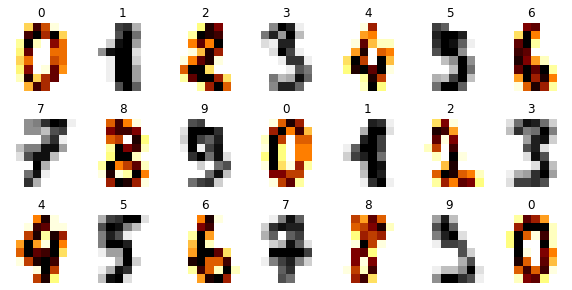

In [151]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [152]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

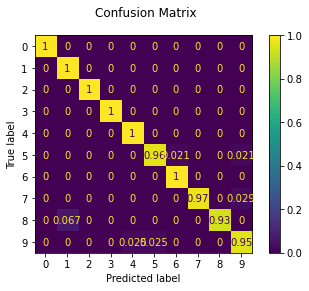

In [164]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [165]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Some numbers looks similar.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

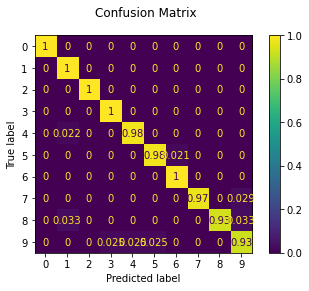

1.0 0.9777777777777777


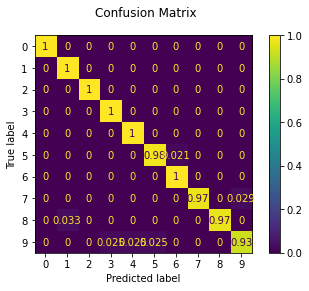

1.0 0.9833333333333333


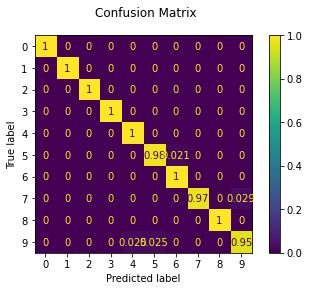

1.0 0.9888888888888889


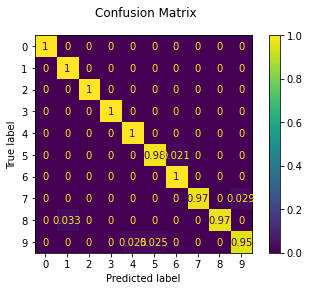

1.0 0.9861111111111112


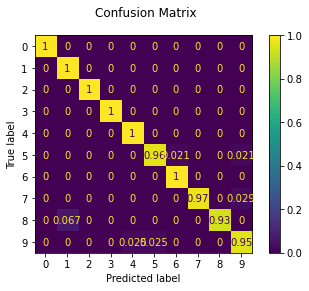

1.0 0.9805555555555555


In [160]:
## your code
for k in [2, 4, 6, 8, 10]:
    model = CustomKNeighborsClassifier(n_neighbors=k, weights='distance')
    model.fit(X_train, list(map(str, y_train)));
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test);
    print(train_acc, test_acc)

n_neighbors = 6 looks great )

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

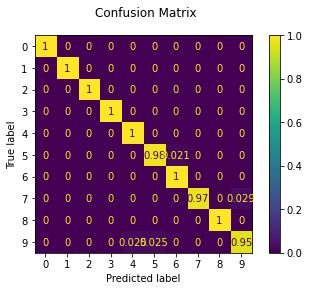

0.9895615866388309 0.9888888888888889


In [162]:
## your code
model = KNeighborsClassifier(n_neighbors=6, weights='uniform')
model.fit(X_train, list(map(str, y_train)));
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test);
print(train_acc, test_acc)

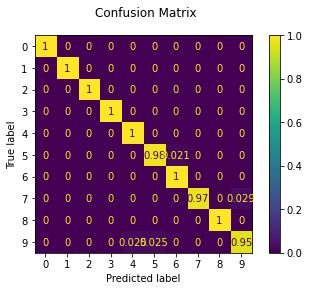

1.0 0.9888888888888889


In [163]:
model = KNeighborsClassifier(n_neighbors=6, weights='distance')
model.fit(X_train, list(map(str, y_train)));
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test);
print(train_acc, test_acc)

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Hamming distance, Jaccard distance ...

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Implementin Hamming distance

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [ ]:
#PATH = "./data/"

In [166]:
data = pd.read_csv('train.csv').set_index('PassengerId')

In [167]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [168]:
## your code
men = len(data[data['Sex'] == 'male']);
women = len(data[data['Sex'] == 'female']);
men_s = len(data[(data['Sex'] == 'male') & (data['Survived'] == 1)]);
women_s = len(data[(data['Sex'] == 'female') & (data['Survived'] == 1)]);
all_pass = men + women;
print(f'Number of men on the titanic = {men} ({men / all_pass} %), number of survived = {men_s} ({men_s / men}) %');
print(f'Number of women on the titanic = {women} ({women / all_pass} %), number of survived = {women_s} ({women_s / women}) %');

Number of men on the titanic = 56114 (0.56114 %), number of survived = 11548 (0.20579534519014864) %
Number of women on the titanic = 43886 (0.43886 %), number of survived = 31226 (0.7115253155903933) %


Sex
female    AxesSubplot(0.125,0.125;0.775x0.755)
male      AxesSubplot(0.125,0.125;0.775x0.755)
Name: Survived, dtype: object

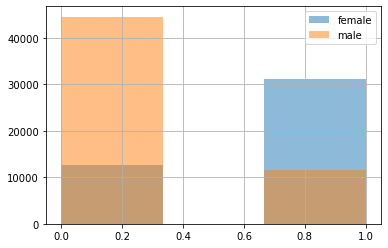

In [169]:
data.groupby('Sex').Survived.hist(legend=True, alpha=0.5, bins=3)

In [812]:
#data['Sex'].replace({0:'male', 1: 'female'},inplace=True);

In [ ]:
#Summary
#Number of men on the titanic = 56114 (0.56114 %), number of survived = 11548 (0.20579534519014864) %
#Number of women on the titanic = 43886 (0.43886 %), number of survived = 31226 (0.7115253155903933) %
#Women survived more then men

< your thoughts >

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:>

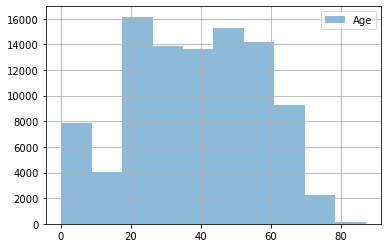

In [170]:
## your code
data.Age.hist(legend=True, alpha=0.5)

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

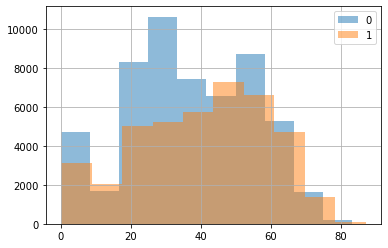

In [171]:
data.groupby('Survived').Age.hist(legend=True, alpha=0.5)

In [172]:
avr_surv = data[data['Survived'] == 1].Age.mean();
median_surv = data[data['Survived'] == 1].Age.median();
print(f'The average age of survived passengers is {avr_surv:2f} years');
print(f'The average age of survived passengers is {median_surv} years');

The average age of survived passengers is 40.553799 years
The average age of survived passengers is 43.0 years


In [173]:
avr_dec = data[data['Survived'] == 0].Age.mean();
median_dec = data[data['Survived'] == 0].Age.median();
print(f'The average age of deceased passengers is {avr_dec:2f} years');
print(f'The average age of deceased passengers is {median_dec} years');

The average age of deceased passengers is 36.708695 years
The average age of deceased passengers is 36.0 years


We can see a lot of children and young people did'n survive. But age difference between survived and deceased passengers is not big.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Pclass, dtype: object

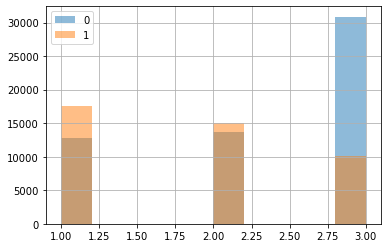

In [174]:
## your code
data.groupby('Survived').Pclass.hist(legend=True, alpha=0.5)

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Embarked, dtype: object

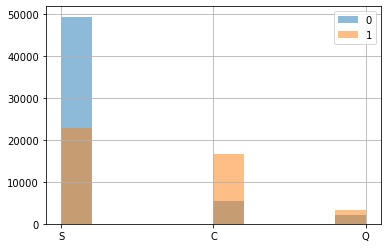

In [175]:
data.groupby('Survived').Embarked.hist(legend=True, alpha=0.5)

We can see the Frst class was "the safest" and "th safest" embarkation port is C (Cherbourg)

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [176]:
## your code
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


In [177]:
count_pass = len(data);
print(f"Number of passengers is {count_pass}");
print(f"Age nan-values is {data['Age'].isna().sum() / len(data['Age']) * 100} %");
print(f"Ticket nan-values is {data['Ticket'].isna().sum() / len(data['Ticket']) * 100} %");
print(f"Fare nan-values is {data['Fare'].isna().sum() / len(data['Fare']) * 100} %");
print(f"Cabin nan-values is {data['Cabin'].isna().sum() / len(data['Cabin']) * 100} %");
print(f"Embarked nan-values is {data['Embarked'].isna().sum() / len(data['Embarked']) * 100} %");

Number of passengers is 100000
Age nan-values is 3.292 %
Ticket nan-values is 4.623 %
Fare nan-values is 0.134 %
Cabin nan-values is 67.866 %
Embarked nan-values is 0.25 %


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

We can replace missung values for mean or median values, or most popular value ..

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [179]:
## your code
data['Sex'].replace('female', 0,inplace=True)
data['Sex'].replace('male', 1,inplace=True)
data['Embarked'].replace('S', 0,inplace=True)
data['Embarked'].replace('C', 1,inplace=True)
data['Embarked'].replace('Q', 2,inplace=True)

In [181]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",1,NaN,2,0,209245,27.14,C12239,0.0
1,0,3,"Bryan, Drew",1,NaN,0,0,27323,13.35,NaN,0.0
2,0,3,"Owens, Kenneth",1,0.33,1,2,CA 457703,71.29,NaN,0.0
3,0,3,"Kramer, James",1,19.00,0,0,A. 10866,13.04,NaN,0.0
4,1,3,"Bond, Michael",1,25.00,0,0,427635,7.76,NaN,0.0


In [182]:
data = data.drop(["Cabin","Name","Ticket"],axis=1)

In [183]:
age_mean = data['Age'].median()
data["Age"].fillna(age_mean, inplace = True)
fare_mean = data['Fare'].median()
data["Fare"].fillna(fare_mean, inplace = True)

In [184]:
data.dropna(inplace=True)

In [185]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99750 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  99750 non-null  int64  
 1   Pclass    99750 non-null  int64  
 2   Sex       99750 non-null  int64  
 3   Age       99750 non-null  float64
 4   SibSp     99750 non-null  int64  
 5   Parch     99750 non-null  int64  
 6   Fare      99750 non-null  float64
 7   Embarked  99750 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 6.8 MB


In [186]:
x_train = data.drop("Survived",axis=1);
y_train = data["Survived"];

In [187]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=45)

In [188]:
model = LogisticRegression();
model.fit(X_train,Y_train)
pred = model.predict(X_test);
accuracy_score(Y_test,pred)

C:\Users\Anetta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7564578111946533

In [189]:
results = cross_validate(model, x_train, y_train, cv=5, return_train_score=True)
print(np.mean(results['train_score']))
print(np.mean(results['test_score']))

C:\Users\Anetta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Anetta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

0.758107769423559
0.7579448621553885


C:\Users\Anetta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [190]:
knn = KNeighborsClassifier()
knn.fit(X_train,Y_train)
pred = knn.predict(X_test);
accuracy_score(Y_test,pred)

0.7184628237259816

In [191]:
results = cross_validate(knn, x_train, y_train, cv=5, return_train_score=True)
print(np.mean(results['train_score']))
print(np.mean(results['test_score']))

0.8059448621553884
0.721874686716792


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [192]:
## your code
data = pd.read_csv('train.csv').set_index('PassengerId');
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [193]:
data['Family'] = data['SibSp'] + data['Parch'] + 1;

In [194]:
data = data.drop('SibSp', axis=1)
data = data.drop('Parch', axis=1)

In [195]:
data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Family
PassengerId,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,209245,27.14,C12239,S,3
1,0,3,"Bryan, Drew",male,NaN,27323,13.35,NaN,S,1
2,0,3,"Owens, Kenneth",male,0.33,CA 457703,71.29,NaN,S,4
3,0,3,"Kramer, James",male,19.00,A. 10866,13.04,NaN,S,1
4,1,3,"Bond, Michael",male,25.00,427635,7.76,NaN,S,1


In [196]:
data = data.drop(["Cabin","Name","Ticket"],axis=1)

In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Sex       100000 non-null  object 
 3   Age       96708 non-null   float64
 4   Fare      99866 non-null   float64
 5   Embarked  99750 non-null   object 
 6   Family    100000 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 6.1+ MB


In [198]:
data["Embarked"].mode()

0    S
dtype: object

In [199]:
data["Age"] = (data["Age"].fillna(data["Age"].median()));
data["Embarked"] = data["Embarked"].fillna("S");

In [200]:
data['Sex'].replace('female', 0,inplace=True)
data['Sex'].replace('male', 1,inplace=True)
data['Embarked'].replace('S', 0,inplace=True)
data['Embarked'].replace('C', 1,inplace=True)
data['Embarked'].replace('Q', 2,inplace=True)

In [201]:
data['Adult'] = 0;
data['Adult'][data["Age"] >= 18] = 1;

C:\Users\Anetta\AppData\Local\Temp/ipykernel_5732/3368858006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Adult'][data["Age"] >= 18] = 1;


In [202]:
data = data.drop(["Age"],axis=1)

In [205]:
data["Fare"] = (data["Fare"].fillna(data["Fare"].median()));

In [206]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Sex       100000 non-null  int64  
 3   Fare      100000 non-null  float64
 4   Embarked  100000 non-null  int64  
 5   Family    100000 non-null  int64  
 6   Adult     100000 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 6.1 MB


In [207]:
x_train = data.drop("Survived",axis=1);
y_train = data["Survived"];

In [208]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [209]:
model = LogisticRegression(C=1);
model.fit(X_train,Y_train)
pred = model.predict(X_test);
accuracy_score(Y_test,pred)

C:\Users\Anetta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7585666666666666

In [210]:
results = cross_validate(model, x_train, y_train, cv=5, return_train_score=True)
print(np.mean(results['train_score']))
print(np.mean(results['test_score']))

C:\Users\Anetta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7581200000000001
0.75816


In [217]:
for k in [2, 15, 20, 25, 30]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,Y_train)
    pred = knn.predict(X_test);
    print(k, accuracy_score(Y_test,pred))

2 0.6924333333333333
15 0.7557333333333334
20 0.7568666666666667
25 0.7588333333333334
30 0.7595


In [218]:
knn = KNeighborsClassifier(n_neighbors=30)
results = cross_validate(knn, x_train, y_train, cv=5, return_train_score=True)
print(np.mean(results['train_score']))
print(np.mean(results['test_score']))

0.7721525
0.7581600000000002


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [219]:
#i didn't understand clearly how to put in kaggele with score https://www.kaggle.com/code/anetta314159/notebook00f1c85f5f